# Описание проекта

Есть данные об автомобилях с интернет-сервиса объявлений. Необходимо построить модель, которая максимально точно предсказывала бы цену автомобиля. Помимо точности важна также скорость обучения и предсказания.


# Используемые библиотеки
Pandas, numpy, seaborn, matplotlib, sklearn, lightgbm

## План исследования
1. Подготовка данных
2. Обучение разных моделей с различными гиперпараметрами
3. Анализ скорости работы и качества моделей  
Общий вывод

# 1. Подготовка данных <a id='section1'></a>

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

Загрузим данные

In [2]:
df = pd.read_csv('autos.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Есть пропуски в категориальных признаках. Для них будут созданны отдельные колонки при использовании get_dummies.

Переведем категориальные признаки в тип category.

In [3]:
df['VehicleType'] = df['VehicleType'].astype('category')
df['Gearbox'] = df['Gearbox'].astype('category')
df['Model'] = df['Model'].astype('category')
df['FuelType'] = df['FuelType'].astype('category')
df['Brand'] = df['Brand'].astype('category')
df['NotRepaired'] = df['NotRepaired'].astype('category')
df['RegistrationMonth'] = df['RegistrationMonth'].astype('category')

#### Проверим количественные переменные

In [4]:
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer',
       'NumberOfPictures']

stats = pd.DataFrame(index = numeric, columns=['Min', 'Max', 'Mean', 'Median'])

for column in numeric:
    stats.loc[column, 'Min'] = df[column].min()
    stats.loc[column, 'Max'] = df[column].max()
    stats.loc[column, 'Mean'] = df[column].mean()
    stats.loc[column, 'Median'] = df[column].median()
    
stats

,Min,Max,Mean,Median
Price,0,20000,4416.66,2700
RegistrationYear,1000,9999,2004.23,2003
Power,0,20000,110.094,105
Kilometer,5000,150000,128211,150000
NumberOfPictures,0,0,0,0


Выявлены следующие проблемы:<br/> 
1) Нулевая цена <br/>
2) Нулевая мощность и слишком высокая максимальная мощность <br/>
3) Ни у одного объявления нет фотографий <br/>
4) Аномалии в годе регистрации

1) Нулевая цена

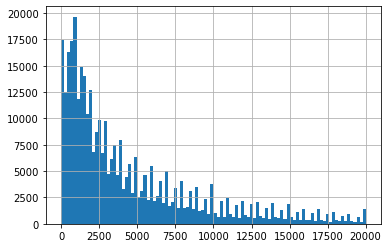

In [5]:
df.Price.hist(bins=100)

Встречается много машин с подозрительно низкой стоимостью, даже нулевой. Удалим все данные с ценой ниже 50.

In [6]:
df = df.query('Price > 50')

2) Нулевая мощность и слишком высокая максимальная мощность

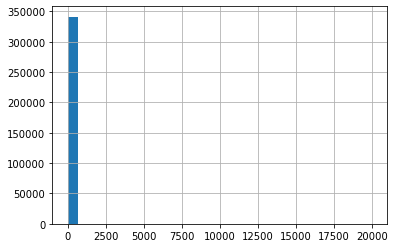

In [7]:
df.Power.hist(bins = 30)

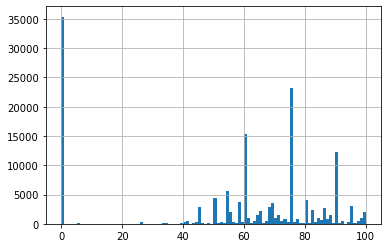

In [8]:
df.Power.hist(range=(0,100), bins = 100)

Большинство значений укладывается в промежуток от 40 до 600. Оставим только такие значения, но без нулевых. 

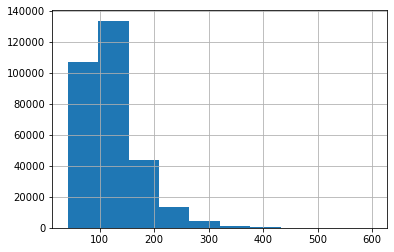

In [9]:
df = df.query('40 < Power <= 600')
df.Power.hist()

3) Ни у одного объявления нет фотографий

Удалим колонку NumberOfPictures, т.к. она неинформативна. 

In [10]:
df = df.drop(['NumberOfPictures'], axis=1)

4) Аномалии в годе регистрации

Самый старый автомобиль в мире выпущен в 1884 году. Предоставленны по объявлениям за 2006 год. Этими годами и ограничимся. 

In [11]:
df = df.query('1884 <= RegistrationYear <= 2006')

#### Проверим категориальные переменные

Почтовый индекс — категориальный признак, но его разнообразие слишком велико. Обработать его не представляется возможным. 

In [12]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']

In [13]:
for word in categorical:
    print(df[word].value_counts())
    print()
    print()

sedan          62677
small          50398
wagon          41369
bus            17413
convertible    14299
coupe          11129
suv             6057
other           1889
Name: VehicleType, dtype: int64


manual    165604
auto       39784
Name: Gearbox, dtype: int64


golf       17627
other      15551
3er        14173
polo        8155
corsa       7702
           ...  
citigo         0
b_max          0
ceed           0
cc             0
serie_1        0
Name: Model, Length: 250, dtype: int64


3     21340
6     19423
5     17923
4     17782
7     16864
10    16012
12    15492
0     14913
11    14799
9     14435
1     13919
8     13515
2     12829
Name: RegistrationMonth, dtype: int64


petrol      143437
gasoline     50314
lpg           3952
cng            252
other           47
hybrid          42
electric        11
Name: FuelType, dtype: int64


volkswagen        45194
opel              24663
bmw               23970
mercedes_benz     21568
audi              17700
ford              14749
re

Обнаружена только проблема в месяце регистрации. Месяцев получилось 13. Можно предположить, что нулями просто были заполнены пропуски. Мне кажется, это не повлияет на качество моделей. 

В данных остались пропуски. Удалять или заполнять их кажется нецелесообразным, т.к. пропущенное значение тоже может влиять на цену. Для пропусков будут созданы отдельные колонки при использовании функции get_dummies.

#### Удалим дубликаты

In [14]:
df = df.drop_duplicates()

#### Проверим численные переменные на корреляцию 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D693148>,
      dtype=object)

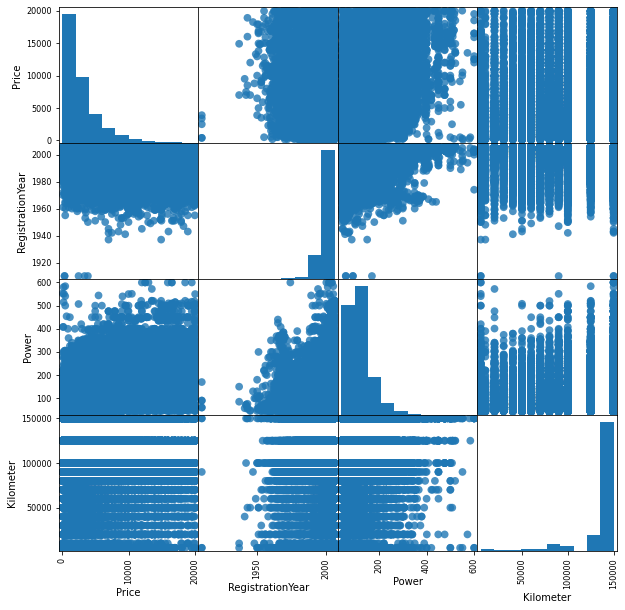

In [15]:
df_n = df.drop(['DateCrawled', 'VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)
pd.plotting.scatter_matrix(df_n, figsize=(10,10), marker = 'o', hist_kwds = {'bins': 10}, s = 60, alpha = 0.8)

Явной корреляции не обнаруженно

#### Определим features и target

In [16]:
features = df.drop(['DateCrawled', 'Price', 'LastSeen', 'PostalCode', 'DateCreated'], axis=1)
target = df['Price']

Используем фенкцию get_dummies

In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209242 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        205227 non-null  category
 1   RegistrationYear   209242 non-null  int64   
 2   Gearbox            205384 non-null  category
 3   Power              209242 non-null  int64   
 4   Model              200642 non-null  category
 5   Kilometer          209242 non-null  int64   
 6   RegistrationMonth  209242 non-null  category
 7   FuelType           198051 non-null  category
 8   Brand              209242 non-null  category
 9   NotRepaired        175198 non-null  category
dtypes: category(7), int64(3)
memory usage: 8.0 MB


In [18]:
features = pd.get_dummies(features, drop_first = True, dummy_na = True)

Разделим данные на тренировочные и тестовые

In [19]:
features.VehicleType_coupe

2         0
3         0
5         0
6         0
9         0
         ..
354358    0
354362    0
354366    0
354367    0
354368    0
Name: VehicleType_coupe, Length: 209242, dtype: uint8

In [20]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=1234)

#### Вывод:
Данные изучены и предобработаны. Определены и подготовлены признаки для обучения моделей.

# 2. Обучение разных моделей с различными гиперпараметрами <a id='section2'></a>

### 2.1 Линейная регрессия

Назначим переменную для модели, заренее укажем параметр n_jobs = -1, для ускорения работы.

In [21]:
model_linear = LinearRegression(n_jobs = -1)

Обучим модель

In [22]:
%%time
model_linear.fit(features_train, target_train)

Wall time: 2.74 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Рассчитаем RMSE модели

In [23]:
%%time
rmse_linear = (mean_squared_error(target_test, model_linear.predict(features_test))) ** 0.5
rmse_linear

Wall time: 96 ms


1932.3990071032542

Линейная регрессия показала RMSE 1932 время обучения 2740 мс и время предсказания 96 мс

### 2.2 Случайный лес

Сделаем все тоже самое, что и с линейной регрессией, но дополнительно для подбора параметров используем RandomizedSearchCV.

In [24]:
model_RFR = RandomForestRegressor(n_jobs = -1)
model_RFR.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [25]:
parameters_grid = {
    'n_estimators' : range(10,100,10),
    'min_samples_split' : range(2,10,1),
    'min_samples_leaf' : range(2,10,1),
    'max_depth' : range(2,30,2),
}

In [26]:
# %%time
# randomized_grid_cv = RandomizedSearchCV(model_RFR, parameters_grid, 
#                                                     scoring=make_scorer(mean_squared_error,greater_is_better=False),
#                                                     n_iter=20                                                    
#                                                    )
# randomized_grid_cv.fit(features_train, target_train)
# randomized_grid_cv.best_params_

Wall time: 47min 55s

{'n_estimators': 30,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_depth': 24}

In [27]:
model_RFR = RandomForestRegressor(
    n_estimators=30,
    min_samples_split=8, 
    min_samples_leaf=4, 
    max_depth=24, 
    random_state=1234,
    n_jobs = -1
)

In [28]:
%%time
model_RFR.fit(features_train, target_train)

Wall time: 47.6 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                      oob_score=False, random_state=1234, verbose=0,
                      warm_start=False)

In [29]:
%%time
rmse_RFR = (mean_squared_error(target_test, model_RFR.predict(features_test))) ** 0.5
rmse_RFR

Wall time: 322 ms


1378.9947913697529

Модель случайного леса показала RMSE 1379 время обучения 47600 мс и время предсказания 322 мс

#### Проверим важность признаков

Мне кажется, не совсем верно сравнивать признаки в "разбитом" состоянии (например каждая модель автомобиля оценивается как отдельный признак). Важность категориальных признаков стоит сложить. Например, важность всех марок мы складываем и объеденяем в признак Brand.

In [30]:
importances = pd.DataFrame(index = features.columns,   # Создадим таблицу с важностью признаков
                     columns=['Feature', 'Importance'])
importances.Importance = model_RFR.feature_importances_

importances.Feature = importances.index

def feature_group(feature): # Функция будет оставлять только наименование признака, без его значения 
    if '_' in feature:      # Например NotRepaired_yes превратит просто в NotRepaired
        group = feature[ : feature.find("_")]
        return group
    else:
        return feature

importances.Feature = importances.Feature.apply(feature_group) # применим функцию к столбцу Feature

importances = importances.groupby(by=['Feature']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances

,Feature,Importance
0,Power,0.431209
1,RegistrationYear,0.288030
2,Model,0.070669
3,VehicleType,0.060346
4,Brand,0.049900
5,Kilometer,0.043129
6,NotRepaired,0.027598
7,RegistrationMonth,0.017173
8,FuelType,0.007507
9,Gearbox,0.004438


(-1.1029992469540681,
 1.1001428212835271,
 -1.1030819329533585,
 1.126977697486415)

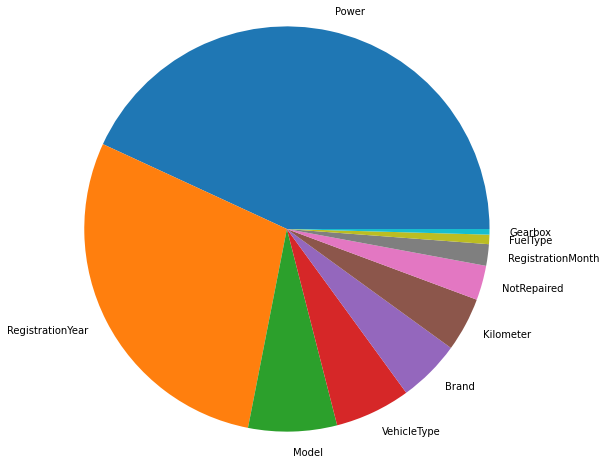

In [31]:
vals = importances['Importance'][0:10] # Исключим NumberOfPictures, т.к. его значение 0
labels = importances['Feature'][0:10]
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vals, labels=labels, pctdistance=1)
ax.axis("equal")

Как видно на диаграмме, для модели случайного леса самыми важными оказались мощность и год регистрации. Интересно, что месяц регистрации оказался более важным, чем тип двигатели или каробки передач. 

### 2.3 LightGBM

Повторим все шаги как с моделью случайного леса

In [32]:
model_LGBM = lgb.LGBMRegressor(n_jobs = -1)
model_LGBM.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [33]:
parameters_grid = {
    'max_depth' : range(5, 20, 1),
    'num_leaves' : range(70,130,5),
    'learning_rate' : np.arange(0.3, 0.9, 0.05),
    'n_estimators' : range(80, 120, 5),
}

In [34]:
# %%time
# randomized_grid_cv = RandomizedSearchCV(model_LGBM, parameters_grid, n_iter=50,
#                                                     scoring=make_scorer(mean_squared_error,greater_is_better=False))

# randomized_grid_cv.fit(features_train, target_train)
# randomized_grid_cv.best_params_

Wall time: 3min 8s

{'num_leaves': 125, 'n_estimators': 115, 'max_depth': 16, 'learning_rate': 0.3}

In [35]:
model_LGBM = lgb.LGBMRegressor(random_state=1234, num_leaves = 125, learning_rate = 0.3, max_depth = 16, n_estimators = 115,
                              n_jobs = -1)

In [36]:
%%time
model_LGBM.fit(features_train, target_train, eval_set = [(features_train, target_train)])

[1]	training's l2: 6.08071e+06
[2]	training's l2: 4.30234e+06
[3]	training's l2: 3.35148e+06
[4]	training's l2: 2.81148e+06
[5]	training's l2: 2.48959e+06
[6]	training's l2: 2.28922e+06
[7]	training's l2: 2.15113e+06
[8]	training's l2: 2.05872e+06
[9]	training's l2: 1.98963e+06
[10]	training's l2: 1.92185e+06
[11]	training's l2: 1.88101e+06
[12]	training's l2: 1.84074e+06
[13]	training's l2: 1.81568e+06
[14]	training's l2: 1.78647e+06
[15]	training's l2: 1.76551e+06
[16]	training's l2: 1.74864e+06
[17]	training's l2: 1.72518e+06
[18]	training's l2: 1.71267e+06
[19]	training's l2: 1.70276e+06
[20]	training's l2: 1.69404e+06
[21]	training's l2: 1.68635e+06
[22]	training's l2: 1.67693e+06
[23]	training's l2: 1.66234e+06
[24]	training's l2: 1.65736e+06
[25]	training's l2: 1.64454e+06
[26]	training's l2: 1.64035e+06
[27]	training's l2: 1.63511e+06
[28]	training's l2: 1.62537e+06
[29]	training's l2: 1.61426e+06
[30]	training's l2: 1.60485e+06
[31]	training's l2: 1.60169e+06
[32]	training's l

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=16,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=115, n_jobs=-1, num_leaves=125, objective=None,
              random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
%%time
rmse_linear = (mean_squared_error(target_test, model_LGBM.predict(features_test))) ** 0.5
rmse_linear

Wall time: 456 ms


1351.4496332662789

LightGBM показал RMSE 1351 время обучения 2140 мс и время предсказания 456 мс

#### Проверим важность признаков

Сделаем все то же, что и со случайным лесом

In [38]:
importances = pd.DataFrame(index = features.columns,
                     columns=['Feature', 'Importance'])

importances.Importance = model_LGBM.feature_importances_

importances.Feature = importances.index

importances.Feature = importances.Feature.apply(feature_group)

importances = importances.groupby(by=['Feature']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances

,Feature,Importance
0,Power,3405
1,RegistrationYear,3174
2,Model,1970
3,VehicleType,1170
4,Brand,1090
5,Kilometer,1061
6,RegistrationMonth,1014
7,NotRepaired,472
8,FuelType,443
9,Gearbox,361


(-1.108608814061177, 1.1004099435267227, -1.104028528059828, 1.113185078051034)

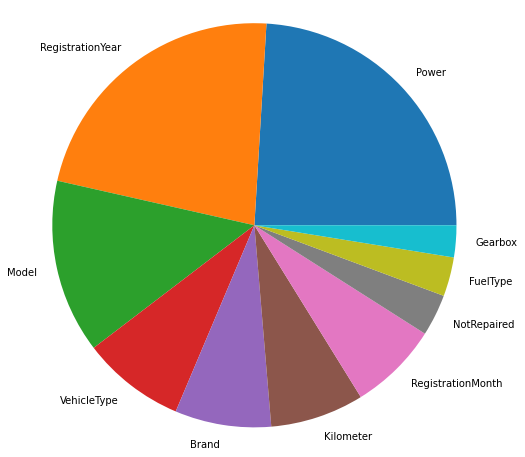

In [39]:
vals = importances['Importance'][0:10] # Также исключим NumberOfPictures, т.к. его значение 0
labels = importances['Feature'][0:10]
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vals, labels=labels, pctdistance=1)
ax.axis("equal")

Самыми важными также оказались мощность и год регистрации. Остальные признаки в этот раз преобрили немного больше значимости. 

#### Вывод:
Были подобраны оптимальные параметры для моделей. Наибольшую точность показал LightGBM.

# 3. Анализ скорости работы и качества моделей <a id='section3'></a>

Создадим таблицу с RMSE, а также скоростью обучения и предсказания. 

In [40]:
result = pd.DataFrame([['Linear', 1932, 2580, 91], ['RandomForest', 1379, 46700, 318], ['LightGBM', 1351, 5290, 462]],
                     columns=['Model', 'RMSE', 'fit', 'predict'])

In [42]:
result

,Model,RMSE,fit,predict
0,Linear,1932,2580,91
1,RandomForest,1379,46700,318
2,LightGBM,1351,5290,462


#### Вывод:
Самой быстрой оказалась модель линейной регрессии, но ее качество предсказаний почти в полтора раза ниже, чем у других моделей. 

Модель случайного леса показала качество предсказаний соизмеримое с LightGBM, но время обучения слишком долгое. 

LightGBM показал самую высокое качество предсказаний, а также оптимальную скорость обучения. 

# Общий вывод <a id='section4'></a>

Была проведена предобработка данных. Подготовленны признаки для работы с тремя моделями (линейная регрессия, случайный лес и LightGBM).

Для моделей подобраны оптимальные параметры. У каждой модели была рассчитана RMSE и зафиксировано время обучения/предсказания.

Наилучшее качество предсказания показал LightGBM (RMSE = 1351). Соизмеримое качество достигнуто и моделью случайного леса (RMSE = 1379). Худшие предсказания получены моделью линейной регрессии (RMSE = 1932).

Самой быстрой оказалась модель линейной регрессии. Но она не подходит по качеству предсказания. Модель случайного леса, несмотря на хороший показатель RMSE, обучается слишком долго. Более, чем в 10 раз дольше других моделей. 

Самой оптимальной оказалась модель LightGBM.